# Python и статистика

Проект №5 - сравнение средних значений (дисперсионный анализ).

# Введение

## Общая постановка задачи

Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

1. Тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные;

2. Была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый.

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

## Задачи

1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выберите формулу для модели, проведите проверку для обоих наборов данных.

## Описание данных

*5_task_1*:

- ```id``` – id клиента в эксперименте
- ```group``` – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- ```events``` – сколько блюд суммарно было заказано за период

*5_task_2*:

- ```id``` – id клиента в эксперименте
- ```segment``` – сегмент (high/low)
- ```group``` – вид кнопки (control – старая версия, test – новая версия)
- ```events``` – сколько блюд суммарно было заказано за период

# Предварительная работа с данными

## Загрузка библиотек

In [1]:
import pandas as pd

import numpy as np
import scipy as sp

import pingouin as pg

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [2]:
task1 = pd.read_csv('./data/5_task_1.csv')
task2 = pd.read_csv('./data/5_task_2.csv')

In [3]:
task1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [4]:
task2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


## Предобработка данных

### Проверка на дубликаты и отсутствующие значения:

In [5]:
import spelling

a10 = task1.shape[0]
a11 = task1.shape[1]
a12 = task1.dropna().shape[0]
a13 = task1.drop_duplicates().shape[0]

print("Таблица с данными для теста №1:")
print(a10, spelling.rows_word(a10), "и", a11, spelling.cols_word(a11))
print(a12, spelling.rows_word(a12), "после удаления строк, содержащих NULL")
print(a13, spelling.rows_word(a13), "после удаления дубликатов")

Таблица с данными для теста №1:
30000 строк и 3 колонки
30000 строк после удаления строк, содержащих NULL
30000 строк после удаления дубликатов


In [6]:
a20 = task2.shape[0]
a21 = task2.shape[1]
a22 = task2.dropna().shape[0]
a23 = task2.drop_duplicates().shape[0]

print("Таблица с данными для теста №2:")
print(a20, spelling.rows_word(a20), "и", a21, spelling.cols_word(a21))
print(a22, spelling.rows_word(a22), "после удаления строк, содержащих NULL")
print(a23, spelling.rows_word(a23), "после удаления дубликатов")

Таблица с данными для теста №2:
100000 строк и 4 колонки
100000 строк после удаления строк, содержащих NULL
100000 строк после удаления дубликатов


### Проверка типов данных

In [7]:
task1.dtypes

id         int64
group     object
events     int64
dtype: object

In [8]:
task2.dtypes

id           int64
group       object
segment     object
events     float64
dtype: object

In [9]:
task2.dtypes

id           int64
group       object
segment     object
events     float64
dtype: object

In [10]:
task2['events'] = task2['events'].astype('int64')

# Решение поставленных задач

# Тест 1

Проверим, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9;
- B – квадратные;
- C – прямоугольные 12:4.

In [11]:
task1['group'].value_counts()

B    10000
C    10000
A    10000
Name: group, dtype: int64

Размеры групп одинаковые.

<AxesSubplot:xlabel='group', ylabel='events'>

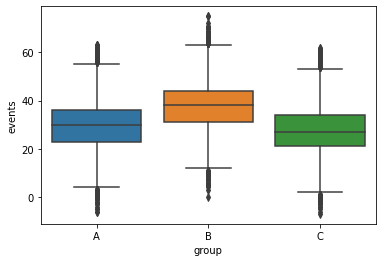

In [12]:
sns.boxplot(data = task1, x = "group", y = "events")

Видно довольно большое количество выбросов.

In [13]:
task1_group_A = task1.query("group == 'A'")['events']
task1_group_B = task1.query("group == 'B'")['events']
task1_group_C = task1.query("group == 'C'")['events']

## Проверка гомогенности дисперсий

Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена

In [14]:
sp.stats.levene(task1_group_A, task1_group_B, task1_group_C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [15]:
pg.homoscedasticity(data = task1, dv = 'events', group = 'group', method = 'levene')

,W,pval,equal_var
levene,2.26226,0.104133,True


## Проверка на нормальность распределения

Проверим распределение данных на нормальность, применив тест Шапиро-Уилка. Перед этим сделаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты.

In [16]:
task1_group_A_sample = task1_group_A.sample(1000, random_state = 17)
task1_group_B_sample = task1_group_B.sample(1000, random_state = 17)
task1_group_C_sample = task1_group_C.sample(1000, random_state = 17)

### Проверка нормальности данных группы 'A'

In [17]:
sp.stats.shapiro(task1_group_A_sample)

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [18]:
pg.normality(task1_group_A_sample)

,W,pval,normal
events,0.997315,0.096096,True


<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

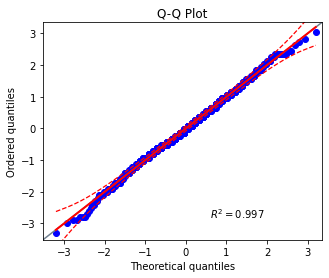

In [19]:
pg.qqplot(task1_group_A_sample, dist = 'norm')

#### Проверки на нормальность без семплирования

In [20]:
sp.stats.shapiro(task1_group_A)

C:\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9989418387413025, pvalue=4.318870651331963e-06)

In [21]:
pg.normality(task1_group_A)

,W,pval,normal
events,0.998942,0.000004,False


<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

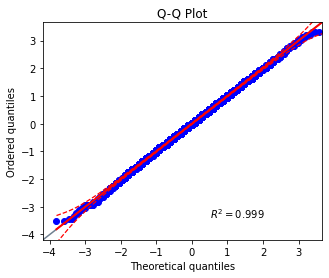

In [22]:
pg.qqplot(task1_group_A, dist = 'norm')

### Проверка нормальности данных группы 'B'

In [23]:
sp.stats.shapiro(task1_group_B_sample)

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

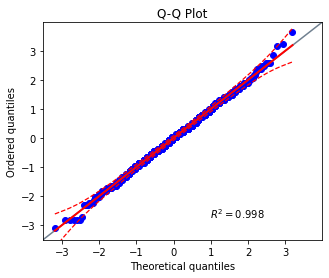

In [24]:
pg.qqplot(task1_group_B_sample, dist = 'norm')

### Проверка нормальности данных группы 'C'

In [25]:
sp.stats.shapiro(task1_group_C_sample)

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

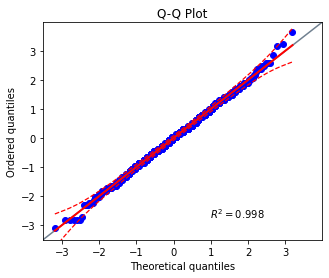

In [26]:
pg.qqplot(task1_group_B_sample, dist = 'norm')

## Сравнение средних

In [27]:
pg.anova(data = task1, dv = 'events', between = 'group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


## Применение критерия Тьюки

Используем данный критерий для определения, между какими группами есть статистически значимые различия.

In [28]:
pg.pairwise_tukey(data = task1, dv = 'events', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


In [29]:
pg.pairwise_gameshowell(data = task1, dv = 'events', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,6.349254e-12,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


In [30]:
pg.pairwise_ttests(data = task1,
                   dv = 'events',
                   between = 'group',
                   padjust = 'bonf',
                   effsize = 'hedges')

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pingouin\bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


In [31]:
pg.pairwise_ttests(data = task1,
                   dv = 'events',
                   between = 'group',
                   padjust = 'sidak',
                   effsize = 'hedges')

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pingouin\bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.0,sidak,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,0.0,sidak,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.0,sidak,inf,1.024138


# Тест 2

In [32]:
task2_group_test    = task2.query("group == 'test'")['events']
task2_group_control = task2.query("group == 'control'")['events']

<AxesSubplot:xlabel='events', ylabel='Count'>

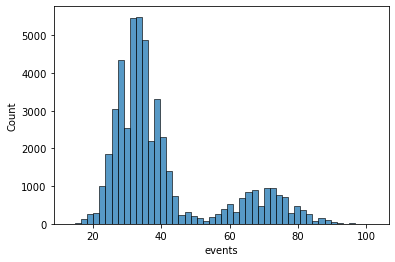

In [33]:
sns.histplot(task2_group_test, bins = 50)

<AxesSubplot:xlabel='events', ylabel='Count'>

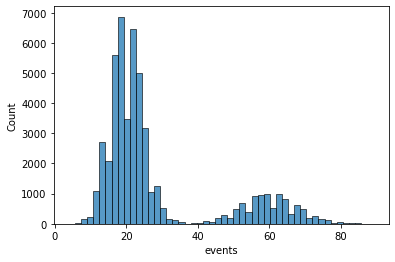

In [34]:
sns.histplot(task2_group_control, bins = 50)

Посчитаем среднее, медиану и стандартное отклонение ```events``` в разбивке по группе и по сегменту пользователя:

In [35]:
task2_group_test_low     = task2.query("(group == 'test') & (segment == 'low')")['events']
task2_group_test_high    = task2.query("(group == 'test') & (segment == 'high')")['events']
task2_group_control_low  = task2.query("(group == 'control') & (segment == 'low')")['events']
task2_group_control_high = task2.query("(group == 'control') & (segment == 'high')")['events']

In [36]:
task2.groupby(['group','segment'])['events'].describe().reset_index()

,group,segment,count,mean,std,min,25%,50%,75%,max
0,control,high,10000.0,59.970800,7.805347,31.0,55.0,60.0,65.0,89.0
1,control,low,40000.0,20.031575,4.473576,4.0,17.0,20.0,23.0,41.0
2,test,high,10000.0,69.938500,8.403974,40.0,64.0,70.0,76.0,102.0
3,test,low,40000.0,33.025925,5.720845,13.0,29.0,33.0,37.0,59.0


Выбираем формулу для модели:

```events ~ segment + group + segment:group``` (если пользоваться ```statsmodels```)

In [37]:
task2['combination'] = task2['group'] + ' / ' + task2['segment']

In [38]:
formula = 'events ~ segment + group + segment:group'

model = ols(formula, task2).fit()

aov_table = anova_lm(model, typ = 2)
aov_table

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377485,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [39]:
pg.anova(data = task2, dv = "events", between = ["segment", "group"])

,Source,SS,DF,MS,F,p-unc,np2
0,segment,2.362480e+07,1.0,2.362480e+07,689756.377485,0.000000e+00,0.873383
1,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
2,segment * group,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [40]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

MultiComp = MultiComparison(task2.events, task2.combination)
print(MultiComp.tukeyhsd().summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control / high control / low -39.9392  -0.0 -40.1073 -39.7711   True
control / high   test / high   9.9677  -0.0   9.7551  10.1803   True
control / high    test / low -26.9449  -0.0  -27.113 -26.7768   True
 control / low   test / high  49.9069  -0.0  49.7388   50.075   True
 control / low    test / low  12.9944  -0.0   12.888  13.1007   True
   test / high    test / low -36.9126  -0.0 -37.0807 -36.7445   True
--------------------------------------------------------------------


In [41]:
pg.pairwise_tukey(data = task2, dv = 'events', between = 'combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control / high,control / low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,6.824282
1,control / high,test / high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.703109
2,control / high,test / low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.603981
3,control / low,test / high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-8.527429
4,control / low,test / low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.220314
5,test / high,test / low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,6.307128


<AxesSubplot:xlabel='group', ylabel='events'>

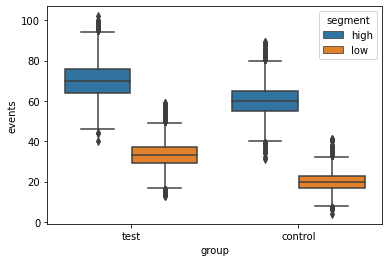

In [42]:
sns.boxplot(data = task2, x = 'group', y = 'events', hue = 'segment')

<AxesSubplot:xlabel='segment', ylabel='events'>

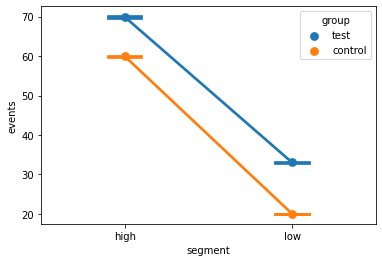

In [43]:
sns.pointplot(x = 'segment', y = 'events', hue = 'group', data = task2, capsize = .2)